In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import feather

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

sys.path.append("../")
from utils import get_logger, log_evaluation, top2accuracy, eval_func, load_datasets, track_experiment

In [2]:
train = pd.read_csv("../data/raw/train_fixed.csv")
test = pd.read_csv("../data/raw/test_fixed.csv")

In [3]:
whole_df = pd.concat([train, test], ignore_index=True)

In [4]:
whole_df["target"] = [1] * len(train) + [0] * len(test)

In [5]:
def load_datasets(feats, debug=False, n=1000):
    if debug:
        train_feats = [feather.read_dataframe(f'../data/features/{feat}_train.feather').head(n) for feat in feats]
        test_feats = [feather.read_dataframe(f'../data/features/{feat}_test.feather').head(n) for feat in feats]
    else:
        train_feats = [feather.read_dataframe(f'../data/features/{feat}_train.feather') for feat in feats]
        test_feats = [feather.read_dataframe(f'../data/features/{feat}_test.feather') for feat in feats]

    train = pd.concat(train_feats, axis=1)
    test = pd.concat(test_feats, axis=1)
    return train, test

In [26]:
X_train, X_test = load_datasets([
            "Base_6",
            "BertPCA50",
            "Momentum",
            "Interaction",
            "SimultaneousPlatformCount",
            "PublisherPCA",
            "DeveloperPCA",
            "Series",
            "NumSeries",
            "NumSeriesNormalized",
            "SeriesLifespan",
            "PublisherDeveloperLDA",
            "DeveloperPublisherLDA",
            "ScoreDiffFromPlatform",
            "ScoreRatioFromPlatform",
            "ScoreDiffFromYear",
            "ScoreRatioFromYear",
            "ScoreDiffFromGenre",
            "ScoreRatioFromGenre",
            "ScoreDiffFromPublisher",
            "ScoreRatioFromPublisher",
            "ScoreDiffFromDeveloper",
            "ScoreRatioFromDeveloper",
            "ScoreDiffFromRating",
            "ScoreRatioFromRating",
            "SeriesOrder",
            "PlatformLDA"
            # "RatingLDA"
        ])

In [38]:
X = pd.concat([X_train, X_test], ignore_index=True)

In [39]:
# ad_val上位で普通の学習でimportance低いやつは消してもええかな
del_cols_ad_val = [
    "publisher_Platform_pca_0",
    "publisher_Year_of_Release_pca_0",
    "publisher_Genre_pca_0",
    "publisher_Developer_lda_20_11"
]
X.drop(del_cols_ad_val, axis=1, inplace=True)

In [40]:
tra_X, val_X, tra_y, val_y = train_test_split(X, whole_df["target"], test_size=0.3, shuffle=True, random_state=0)

In [41]:
# lightGBMを用いて二値分類を解く
num_round = 10000
params = {
    'metric': 'auc',
    'objective': 'binary'
    }

train_data = lgb.Dataset(tra_X, tra_y)
valid_data = lgb.Dataset(val_X, val_y)
model = lgb.train(params, train_data,
                num_boost_round=num_round,
                valid_names=["train", "valid"],
                valid_sets=(train_data, valid_data),
                early_stopping_rounds=100,
                verbose_eval=100
                )

Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 1	valid's auc: 0.999894
Early stopping, best iteration is:
[34]	train's auc: 1	valid's auc: 0.999825


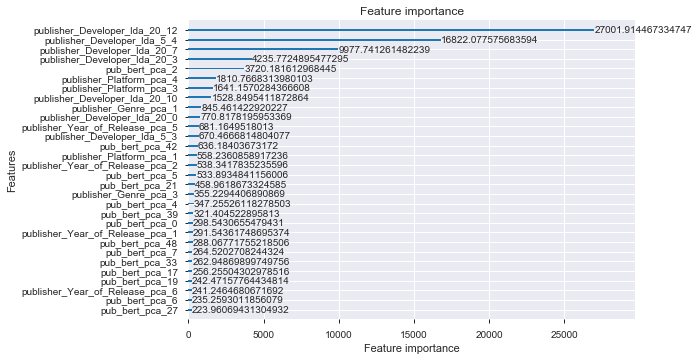

In [42]:
lgb.plot_importance(model, importance_type="gain", max_num_features=30)

In [22]:
import seaborn as sns

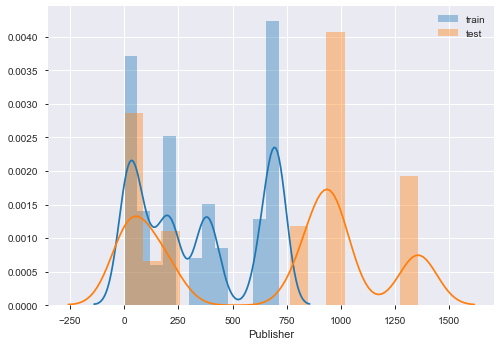

In [25]:
sns.distplot(X_train["Publisher"], label="train")
sns.distplot(X_test["Publisher"], label="test")
plt.legend()

In [31]:
train["Publisher"].value_counts()[:30]

THQ                                       715
Nintendo                                  706
Sony Computer Entertainment               687
Sega                                      638
Take-Two Interactive                      422
Capcom                                    386
Atari                                     367
Tecmo Koei                                348
Warner Bros. Interactive Entertainment    235
Square Enix                               234
Disney Interactive Studios                218
505 Games                                 191
Microsoft Game Studios                    191
D3Publisher                               184
Vivendi Games                             164
Idea Factory                              133
Nippon Ichi Software                      106
Majesco Entertainment                      92
LucasArts                                  90
Bethesda Softworks                         76
Banpresto                                  73
Crave Entertainment               

In [30]:
test["Publisher"].value_counts()[:30]

Electronic Arts                 1356
Activision                       985
Namco Bandai Games               939
Ubisoft                          933
Konami Digital Entertainment     834
Unknown                          201
Eidos Interactive                198
Midway Games                     198
Acclaim Entertainment            186
Codemasters                      150
Deep Silver                      121
Zoo Digital Publishing           104
Rising Star Games                 87
Hudson Soft                       81
5pb                               62
Infogrames                        62
Virgin Interactive                62
Empire Interactive                53
PQube                             45
GT Interactive                    45
DTP Entertainment                 44
Spike                             37
SouthPeak Games                   37
Nordic Games                      37
3DO                               36
Black Bean Games                  34
Psygnosis                         32
G

In [32]:
X_train, X_test = load_datasets(["Base_6","BertPCA","Momentum","Interaction", "SimultaneousPlatformCount", "PublisherPCA", "DeveloperPCA"])

X = pd.concat([X_train, X_test], ignore_index=True)

tra_X, val_X, tra_y, val_y = train_test_split(X, whole_df["target"], test_size=0.3, shuffle=True, random_state=0)

# lightGBMを用いて二値分類を解く
num_round = 10000
params = {
    'metric': 'auc',
    'objective': 'binary'
    }

train_data = lgb.Dataset(tra_X, tra_y)
valid_data = lgb.Dataset(val_X, val_y)
model = lgb.train(params, train_data,
                num_boost_round=num_round,
                valid_names=["train", "valid"],
                valid_sets=(train_data, valid_data),
                early_stopping_rounds=100,
                verbose_eval=100
                )

Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 1	valid's auc: 0.999885
Early stopping, best iteration is:
[41]	train's auc: 1	valid's auc: 0.999851


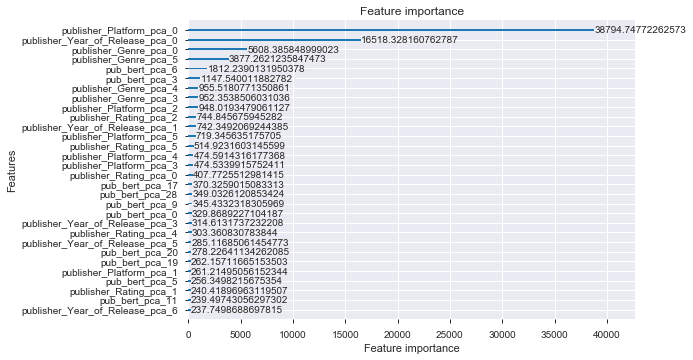

In [33]:
lgb.plot_importance(model, importance_type="gain", max_num_features=30)